In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import itertools

from matplotlib import pyplot as plt
from matplotlib import pyplot
import matplotlib as mptl
import pylab

import tensorflow as tf
from tensorflow import keras as keras


import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.optimizers import Adam, SGD
#from tensorflow.keras.utils import np_utils, plot_model
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix

# note - although not shown here you will need packages hdf5 and h5py installed in your environment

In [2]:
print("Tensorflow version: ", tf.__version__)
print("Tensorflow devices: ", tf.config.list_physical_devices("GPU"))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Tensorflow version:  2.6.0
Tensorflow devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Utilities

In [4]:
# ---------------- Utils -------------------------------

#load data
def load_cifar10_data():
    """Loads the cifar10 image set and generates train and test data
    note that y is converted to categorical (dummy variables)
    :return: x_train, y_train, x_test, y_test, num_classes
    """
    num_classes = 10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    # Convert class vectors to binary class matrices.
    y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
    #y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    return x_train, y_train, x_test, y_test, num_classes


def show_cifar10_images(imageset = range(0, 9)):
    """
    Displays some of the images in CIFAR10
    :param imageset: list of 9 image indexes to display
    :return:
    """
    # load data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    print('X_train shape ', X_train.shape)
    # create a grid of 3x3 images
    for i in imageset:
        pyplot.subplot(330 + 1 + i)
        X = X_train.reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
        pyplot.imshow(X_train[i].reshape(32, 32, 3), cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show(block=False)


def plot_confusion_matrix(cm, class_labels, title='Confusion matrix',
                          filename = 'Confusion_Matrix.png', cmap=plt.cm.Blues):
    """
    Plot a confusion matrix
    :param cm: a confusion matrix generated by sklearn.metrics.confusion_matrix
    :param class_labels: set of text labels
    :param title: title of figure
    :param cmap: color map for the confusion matrix
    :return:
    """
    class_count = len(class_labels)
    fig = plt.figure(title)
    fig.set_size_inches(10, 8)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#     tick_marks = np.arange(class_count+1)
    tick_marks = np.arange(class_count)
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename, dpi=100)
    np.set_printoptions(precision=2)
    plt.show(block=False)


def save_CNN_model(model, save_dir=os.path.join(os.getcwd(), 'saved_models'),
                   model_file_name='keras_cifar10_trained_model.h5'):
    """
    Save model and current weights
    :param model: Keras model
    :param save_dir: path name to save directory
    :param model_file_name: filename for saved model
    :return: nothing
    """
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_file_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)


def load_CNN_model(save_dir, model_file_name):
    # Load model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_file_name)
    model = load_model(model_path)
    print('Loaded trained model from %s ' % model_path)
    return model

# Model Definitions Section
## Provided Models

# Step 1.
## Existing Architecture Documentation:
You have inherited 2 Keras CNN architectures (shallow, deep).  Your goal in this step is to document the models.  Examine the layers of each model in the code (using keras’s tools like .summary), and develop a diagram (e.g. using Powerpoint) of the layers like you’ve seen in class or on the internet.  Save the diagram as an image that can be imported/displayed in your notebook with a code cell near the model’s code.  In a markdown cell, describe the architectures and their parameterization.  How many parameters are there?  What other features are present in these models.  How do they differ?  What is your conjecture about their expected performance on the CIFAR10 dataset?

insert your responses here:

In [5]:
# ---------------- CNN Section -------------------------

def compile_shallow_CNN_model(input_shape, num_classes):
    """Compiles a shallow CNN: conv - maxpool - conv - maxpool - dense - dense
    :param input_shape: tensor shape of the input
    (3 dim for 3 channel color images: colorChannel, height, width)
    :param num_classes: name of the h5 file containing the trained model params
    :return: compiled model
    """
    model = Sequential()
#     model.add(keras.Input(shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['accuracy'])
    return model


def compile_deep_CNN_model(input_shape, num_classes):
    """Compiles a simple deep CNN: with conv, maxpool, dropout
    :param input_shape: tensor shape of the input (not including observation count)
    (3 dim for 3 channel color images)
    :param num_classes: name of the h5 file containing the trained model params
    :return: compiled model
    """
    model = Sequential()
#     model.add(keras.Input(shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    # initiate RMSprop optimizer
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
    # compile the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

# Step 2.
## Training Modification:
Modify the provided training code to enable recording and examining additional information per epoch such as training loss and accuracy and validation loss and accuracy.  Implement early stopping based on the validation set.  You may need to use Keras callbacks in this step.   If you are making decisions using the validation data (i.e. early stopping), remember to not use the same validation data to also evaluate the model’s performance.

describe what changes you made here:

In [6]:
MINIMUM_EPOCHS = 2
def train_cifar10(model, x_train, y_train, x_val, y_val, batch_size=32, epochs = MINIMUM_EPOCHS, data_augmentation=False):
    """
    Train a simple deep CNN on the CIFAR10 small images dataset.
    :param model: Keras model to train
    :param x_train:
    :param y_train: categorical (dummy columns)
    :param x_val:  categorical (dummy columns)
    :param y_val:
    :param batch_size: =32
    :param data_augmentation: =False
    :return: trained model
    """

    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_val, y_val),
                  shuffle=True)
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=epochs,
                            validation_data=(x_val, y_val))
    return model


def eval_cifar10(model, x_test, y_test):
    """Loads and evaluates a model on cifar10 dataset
    :param save_dir: subfolder the model is located in
    :param model_file_name: name of the h5 file containing the trained model params
    :return: nothing is returned from this function
    """
    #initialization
    num_predictions = 20  # sample predictions

    print(x_test.shape[0], 'test samples')
    print("y_test shape: ", y_test.shape)

    # Load label names to use in prediction results
    label_list_path = 'datasets/cifar-10-batches-py/batches.meta'
    keras_dir = os.path.expanduser(os.path.join('~', '.keras'))
    datadir_base = os.path.expanduser(keras_dir)
    if not os.access(datadir_base, os.W_OK):
        datadir_base = os.path.join('/tmp', '.keras')
    label_list_path = os.path.join(datadir_base, label_list_path)
    with open(label_list_path, mode='rb') as f:
        labels = pickle.load(f)

    # report evaluation metrics
    evaluation = model.evaluate(x_test, y_test)
    print()
    print('------------------')
    print('Model Accuracy = %.2f' % (evaluation[1]))
    print()
    print('model metrics: ', evaluation)    # change this if you want other metrics

    # make predictions on all test inputs
    predictions = model.predict(x_test)
    print("prediction shape: ", predictions.shape)

    # build class integers from target dummy variables
    actual_class_IDs = np.argmax(y_test, axis=1)
    # build class integers from predicted dummy variables
    predicted_class_IDs = np.argmax(predictions, axis=1)

    print("actual class ID shape: ", actual_class_IDs.shape)
    print("predicted class ID shape: ", predicted_class_IDs.shape)
    print("labels names: ", labels['label_names'][0:10])

    # display label names
    lab_names = np.asarray(labels['label_names'][0:10])

    # generate & print confusion matrix to screen
    cm = confusion_matrix(actual_class_IDs, predicted_class_IDs)
    print(cm)

    # plot confusion matrix in pretty format
    plot_confusion_matrix(cm, class_labels=lab_names, title='Confusion matrix')

    # ...... show some sample predictions (text only) .......
    for predict_index, predicted_y in enumerate(predictions):
        actual_label = labels['label_names'][np.argmax(y_test[predict_index])]
        predicted_label = labels['label_names'][np.argmax(predicted_y)]
        print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                              predicted_label))
        if predict_index == num_predictions:
            break

    return

Starting script.
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
X_train shape  (50000, 32, 32, 3)


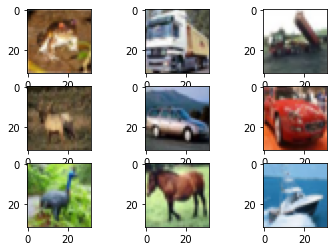

Model Initialization & Compile  Complete
Not using data augmentation.
Epoch 1/2
1563/1563 [==============================] - 17s 9ms/step - loss: 1.8624 - accuracy: 0.3206 - val_loss: 1.5583 - val_accuracy: 0.4439
Epoch 2/2
1563/1563 [==============================] - 15s 9ms/step - loss: 1.5159 - accuracy: 0.4499 - val_loss: 1.3792 - val_accuracy: 0.5025
Model Training Complete
Saved trained model at C:\Users\Brett\Documents\AFIT\courses\CSCE 823\CSCE 823 2022\06-Assignments\HW3\saved_models\saved_models/keras_cifar10_deep_trained_model.h5 
10000 test samples
y_test shape:  (10000, 10)
313/313 [==============================] - 1s 2ms/step - loss: 1.3792 - accuracy: 0.5025

------------------
Model Accuracy = 0.50

model metrics:  [1.3791977167129517, 0.5024999976158142]
prediction shape:  (10000, 10)
actual class ID shape:  (10000,)
predicted class ID shape:  (10000,)
labels names:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[526  44  

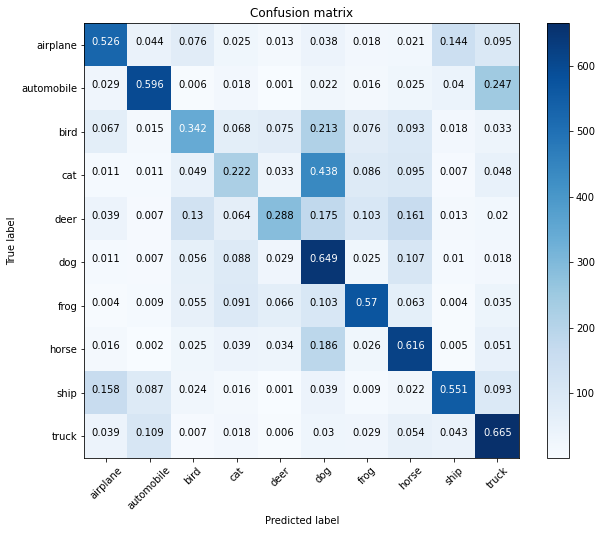

Actual Label = cat vs. Predicted Label = cat
Actual Label = ship vs. Predicted Label = automobile
Actual Label = ship vs. Predicted Label = ship
Actual Label = airplane vs. Predicted Label = ship
Actual Label = frog vs. Predicted Label = frog
Actual Label = frog vs. Predicted Label = frog
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = frog vs. Predicted Label = frog
Actual Label = cat vs. Predicted Label = dog
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = truck vs. Predicted Label = truck
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = truck vs. Predicted Label = truck
Actual Label = ship vs. Predicted Label = truck
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = ship vs. Predicted Label = ship
Actual Label = frog vs. Predicted Label = frog
Actual Label = ho

In [7]:
# =========  MAIN RUNNING CODE  ==================


if __name__ == "__main__":
    print("Starting script.")

    #select activities to perform below
    SHOW_SAMPLES = True  # show examples of CIFAR10 images
    BUILD_MODEL = True  # overwrites current model with initialized parameters
    TRAIN_MODEL = True  # overwrites current model by training
    SAVE_MODEL = True   # saves current model to "model_file_name". should only be used if a model is built or trained
    LOAD_MODEL = False    # overwrites current model with loaded model
    EVAL_MODEL = True    # evaluates performance of model on CIFAR10

    # --------- initializtion -----------
    seed = 10
    np.random.seed(seed)

    save_dir = os.path.join(os.getcwd(), 'saved_models')  # subdirectory for saved models
    model_file_name = 'empty_model.h5'  # placeholder - change model name in BUILD_MODEL section

    model = Sequential()  # this is just an empty model to allow code checking - load or train an actual model below

    # ...... load data ......
    x_train, y_train, x_test, y_test, num_classes = load_cifar10_data()
    input_shape = x_train.shape[1:]
    batch_size = 32

    # --------- show sample images ----------------
    if SHOW_SAMPLES:
        show_cifar10_images()

    # -------------setup model ---------------
    if BUILD_MODEL:
        # *** choose one of these models for training & comment the others out:

#         # ........ Predesigned Model - shallow CNN ...........
#         model = compile_shallow_CNN_model(input_shape, num_classes)
#         model_file_name = 'keras_cifar10_shallow_trained_model.h5'

#       #  ........ Predesigned Model - deeper CNN ...........
        model = compile_deep_CNN_model(input_shape, num_classes)
        model_file_name = 'saved_models/keras_cifar10_deep_trained_model.h5'

        # ........ Student Model - you need to write this function ......
        # model = compile_student_model(input_shape, num_classes)
        # model_file_name = 'keras_cifar10_LASTNAME_final_model.h5'  # (insert your lastname)
        # -------------end setup model---------------
        print("Model Initialization & Compile  Complete")

    # ------------ Execute Training on compiled model -----------------------
    if TRAIN_MODEL:
#         epochs = 40
        epochs = MINIMUM_EPOCHS
        data_augmentation = False
        x_val = x_test  # you can use split val data from training data instead if you wish
        y_val = y_test  # you can use split val data from training data instead if you wish
        model = train_cifar10(model, x_train, y_train, x_val, y_val, batch_size, epochs, data_augmentation)
        print("Model Training Complete")

    # ------------- save the trained model ---------------------
    if SAVE_MODEL:
        save_CNN_model(model, save_dir, model_file_name)

    # ---------- load a saved model later for evaluation --------
    if LOAD_MODEL:
        # Uncomment only the filename you want to load
        model_load_file_name = 'keras_cifar10_shallow_trained_model.h5'  # put the right model name to load here
        #model_load_file_name = 'keras_cifar10_deep_trained_model.h5'
        #model_load_file_name = 'keras_cifar10_LASTNAME_final_model.h5'  # (insert your lastname)
        model = load_CNN_model(save_dir, model_load_file_name)

    # ---------- evaluate the trained model on the test data ----------
    if EVAL_MODEL:
        eval_cifar10(model, x_test, y_test)

    #at end of code, this call to show keeps images on the screen
    plt.show(block=True)

    print("Done. Exiting...")

# PERFORMANCE DOCUMENTATION

# STEP 4.	
## Existing Architecture Performance Evaluation: 

Using the provided code, train and evaluate the two provided Keras CNNs (shallow, deep) on the CIFAR10 dataset on 200 epochs.  Make sure data_augmentation = False.  Produce and discuss the training and validation curves.  What can you tell about these models from these curves.  Do they have enough capacity?  Were they trained long enough?  You may desire to increase the number of training epochs beyond 200 if you have time and the training performance was still improving.  Report standard classification metrics including loss and accuracy as well as a confusion matrix of performance on the test data. Compare the performances of these simple models with best architectures on CIFAR10 (state of the art performance): https://en.wikipedia.org/wiki/CIFAR-10 

insert your response here... note that you will probably need to save & reload performance information recorded during training/test of these networks in order to recreate figures & provide performance info here.  Feel free to use code cells to do this as necessary:  

## STEP 5:  Literature Review
Using the Wikipedia link listed below, and/or a literature search you conduct, locate and discuss at least 3 papers (conference or journal) which provide different approaches to tackling classification on the CIFAR10 dataset and have very good performance.   In your ipython notebook, compare and contrast their architectures and rationale for the researchers choices.  Include images or use other ways to describe the architectures.  Compare/contrast model performances.

## STEP 6: Student Model
Your architecture can be inspired by other architectures you might have seen, but it should be your own.  Code up your model in Keras in the cell below:

In [8]:
#note - you may need to move this student model definition before the code that uses it
# in order for your python code that calls it to run

def compile_student_model(input_shape, num_classes):
    """Compiles a student-designed CNN: with various layers
    :param input_shape: tensor shape of the input (not including observation count)
    (3 dim for 3 channel color images)
    :param num_classes: name of the h5 file containing the trained model params
    :return: compiled model
    """
    model = Sequential()  #note:  you dont have to use sequential model if you want to use keras model api instead
    # ....... add your code to define the model layers here ........
    # ^^^^^^^^^^^^^^^^ put your layer code above  here ^^^^^^^^^^^^^^^^^^
    # using RMSprop use the next line, (but you can pick your own optimizer if you want)
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

### Step 6 (continued) Student Model Design Description:
Cite any sources that inspired your design.  Consider using/altering the various layers (e.g. conv2D, activation, pooling, dropout) as well as the optimizer selection and settings. Develop a diagram (e.g. using architecture display tools or Powerpoint, saved as .png) of the layers like you’ve seen in class or on the internet.  Document your design and your decision rationale.    In a markdown cell, describe the architecture and their parameters.  How many parameters are there?  What other features are present in these models.  How do they differ?  What is your conjecture about their expected performance on the CIFAR10 dataset compared to the instructor-provided architectures?  Compared with state of the art performance?  

insert your documentation for step 6 here:

# STEP 8.
## New Architecture Performance Evaluation:

Train and evaluate your architecture on the CIFAR10 dataset on at least 200 epochs.  Make sure data_augmentation = False.   Examine the training and validation curves during training and include them in your document.  What can you tell about these models from these curves.  Do they have enough capacity?  Were they trained long enough?  Report standard classification metrics including loss and accuracy as well as a confusion matrix.  Compare your performance to both the instructor-provided models and the state-of-the-art performers. Compare your trained model to the instructor-provided model(s) and the model you implemented from the literature (be sure to use the data augmenter to train each model the same way to have a fair comparison).  Document the results of the comparison in your report.

insert your response here... note that you will probably need to save & reload performance information recorded during training/test of these networks in order to recreate figures & provide performance info here.  Feel free to use code cells to do this as necessary:  